## Lab Introduction
Breast cancer usually starts from an uncontrolled growth of the cells that make up the milk-producing ducts. While fairly uncommon with men (less than 0.1% experience it), according to BreastCancer.org, one in eight women (12%) end up developing a malignant form of breast cancer over the course of their lifetime. These invasive cells form tumors that destroy nearby tissue, can spread to other parts of the body, and if not duly addressed, may result in death. To put things into perspective, in the U.S., roughly 600 women die per year due to pregnancy related complications... yet over 40,000 die per year due to breast cancer.

Breast cancer doesn't develop over night and, like any other cancer, can be treated extremely effectively if detected in its earlier stages. Part of the understanding cancer is knowing that not all irregular cell growths are malignant; some are benign, or non-dangerous, non-cancerous growths. A benign tumor does not mean the mass doesn't increase in size, but only means it does not pose a threat to nearby tissue, nor is it likely to spread to other parts of the body. The mass simply stays wherever it's growing. Benign tumors are actually pretty popular, such as moles and some warts. Being able to properly assess if a tumor is actually benign and ignorable, or malignant and alarming is therefore of importance, and also is a problem that might be solvable through data and machine learning.

In this lab, you'll be using the **[Breast Cancer Wisconsin Original](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original))**  data set, provided courtesy of UCI's Machine Learning Repository. Here are the column names, which you can read more details about on the dataset's information page:

**['sample', 'thickness', 'size', 'shape', 'adhesion', 'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'status']**

In [1]:
import random, math
import pandas as pd
import numpy as np
import scipy.io

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot') # Look Pretty


# Leave this alone until indicated:
Test_PCA = False

### A Convenience Function

This method is for your visualization convenience only. You aren't expected to know how to put this together yourself, although you should be able to follow the code by now:

In [2]:
def plotDecisionBoundary(model, X, y):
    print("Plotting...")

    fig = plt.figure()
    ax = fig.add_subplot(111)

    padding = 0.1
    resolution = 0.1

    #(2 for benign, 4 for malignant)
    colors = {2:'royalblue', 4:'lightsalmon'} 


    # Calculate the boundaris
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    # Create a 2D Grid Matrix. The values stored in the matrix
    # are the predictions of the class at at said location
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # What class does the classifier say?
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour map
    plt.contourf(xx, yy, Z, cmap=plt.cm.seismic)
    plt.axis('tight')

    # Plot your testing points as well...
    for label in np.unique(y):
        indices = np.where(y == label)
        plt.scatter(X[indices, 0], X[indices, 1], c=colors[label], alpha=0.8)

    p = model.get_params()
    plt.title('K = ' + str(p['n_neighbors']))
    plt.show()

## 1. Data Preparation

Firstly, download the the [dataset](https://https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Original)). Then, load in the dataset (**breast-cancer-wisconsin.data**), identify nans, and set proper headers. Be sure to verify the rows line up by looking at the file in a text editor.

In [3]:
# .. your code here ..
data = pd.read_csv('breast-cancer-wisconsin.data',sep=',', names= ['sample', 'thickness', 'size', 'shape', 'adhesion', 'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'status'])
data.head()

,sample,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses,status
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
data.corr()

,sample,thickness,size,shape,adhesion,epithelial,chromatin,nucleoli,mitoses,status
sample,1.000000,-0.055308,-0.041603,-0.041576,-0.064878,-0.045528,-0.060051,-0.052072,-0.034901,-0.080226
thickness,-0.055308,1.000000,0.644913,0.654589,0.486356,0.521816,0.558428,0.535835,0.350034,0.716001
size,-0.041603,0.644913,1.000000,0.906882,0.705582,0.751799,0.755721,0.722865,0.458693,0.817904
shape,-0.041576,0.654589,0.906882,1.000000,0.683079,0.719668,0.735948,0.719446,0.438911,0.818934
adhesion,-0.064878,0.486356,0.705582,0.683079,1.000000,0.599599,0.666715,0.603352,0.417633,0.696800
epithelial,-0.045528,0.521816,0.751799,0.719668,0.599599,1.000000,0.616102,0.628881,0.479101,0.682785
chromatin,-0.060051,0.558428,0.755721,0.735948,0.666715,0.616102,1.000000,0.665878,0.344169,0.756616
nucleoli,-0.052072,0.535835,0.722865,0.719446,0.603352,0.628881,0.665878,1.000000,0.428336,0.712244
mitoses,-0.034901,0.350034,0.458693,0.438911,0.417633,0.479101,0.344169,0.428336,1.000000,0.423170
status,-0.080226,0.716001,0.817904,0.818934,0.696800,0.682785,0.756616,0.712244,0.423170,1.000000


In [5]:
nuclei = pd.DataFrame(data['nuclei'])
nuclei.nuclei = pd.to_numeric(nuclei.nuclei, errors = 'coerce')
print(nuclei.iloc[23])
nuclei.dropna(inplace=True)
par= round(np.mean(nuclei),0)
nuclei = pd.DataFrame(data['nuclei'])
nuclei.nuclei = pd.to_numeric(nuclei.nuclei, errors = 'coerce')
nuclei.replace(np.nan,par,inplace=True)
nuclei

nuclei   NaN
Name: 23, dtype: float64


,nuclei
0,1.0
1,10.0
2,2.0
3,4.0
4,1.0
5,10.0
6,10.0
7,1.0
8,1.0
9,1.0


In [6]:
data.nuclei = nuclei.nuclei

In [7]:
print(np.unique(data.nuclei))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


Copy out the status column into a slice, then drop it from the main dataframe. Always verify you properly executed the drop by double checking (printing out the resulting operating)! Many people forget to set the right axis here.

If you goofed up on loading the dataset and notice you have a `sample` column, this would be a good place to drop that too if you haven't already.

In [8]:
# .. your code here ..
y= data['status']
data.drop(labels=['sample','status'], axis=1, inplace=True)

With the labels safely extracted from the dataset, replace any nan values with the mean feature / column value:

Do train_test_split. Use the same variable names as on the EdX platform in the reading material, but set the random_state=7 for reproducibility, and keep the test_size at 0.5 (50%).

In [9]:
data.replace(np.nan, np.mean, inplace=True)
data.head()

,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses
0,5,1,1,1,2,1.0,3,1,1
1,5,4,4,5,7,10.0,3,2,1
2,3,1,1,1,2,2.0,3,1,1
3,6,8,8,1,3,4.0,3,7,1
4,4,1,1,3,2,1.0,3,1,1


In [10]:
# .. your code here ..
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, y, train_size = 0.5, test_size=0.5, random_state=7)

Experiment with the basic SKLearn preprocessing scalers. We know that the features consist of different units mixed in together, so it might be reasonable to assume feature scaling is necessary. Print out a description of the dataset, post transformation. Recall: when you do pre-processing, which portion of the dataset is your model trained upon? Also which portion(s) of your dataset actually get transformed?

In [11]:
# .. your code here ..
data.describe()

,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.555079,3.437768,2.866953,1.589413
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.602496,2.438364,3.053634,1.715078
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


### Dimensionality Reduction

[PCA](https://blog.paperspace.com/dimension-reduction-with-principal-component-analysis/) and [Isomap](https://https://blog.paperspace.com/dimension-reduction-with-isomap/) are your new best friends

In [12]:
from sklearn.manifold import Isomap
model = None
if Test_PCA:
    print("Computing 2D Principle Components")
    model = PCA(n_components=2)
else:
    print("Computing 2D Isomap Manifold")
model = Isomap(n_neighbors=5, n_components=2)

Computing 2D Isomap Manifold


## 2. Training the Model

Train your model against data_train, then transform both `data_train` and `data_test` using your model. You can save the results right back into the variables themselves.

In [13]:
print(X_train.shape)
X_train.head()

(349, 9)


,thickness,size,shape,adhesion,epithelial,nuclei,chromatin,nucleoli,mitoses
28,2,1,1,1,2,1.0,2,1,1
376,1,1,1,1,2,1.0,2,1,1
453,4,5,5,8,6,10.0,10,7,1
401,3,1,1,1,2,1.0,1,1,1
254,9,10,10,1,10,8.0,3,3,1


In [14]:
'''print(y_train.shape)
y_train.head()
y_train=y_train.values.reshape(1,-1)
print(y_train.shape)'''
#print(np.unique(data.nuclei))
X_train.nucleoli

28      1
376     1
453     7
401     1
254     3
414     6
313     1
84     10
62      3
677     1
136     1
111     1
194     1
340     6
510     1
43      1
503     1
492     1
479     5
293     3
129     1
628     1
389     2
218    10
96      1
124    10
660     1
226     9
177    10
465    10
       ..
189     1
112     3
183     8
152    10
325     3
44     10
444     1
6       1
250     1
75      2
512     1
391     9
432     2
68      9
167     1
554     1
366    10
345     1
584     1
535     1
398     2
185     1
348     3
615     1
211     7
579     1
502     1
537     1
196     8
175     7
Name: nucleoli, Length: 349, dtype: int64

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [16]:
# .. your code here ..
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
result = []
for item in range(1,16):
    knmodel = KNeighborsClassifier(n_neighbors=item).fit(X_train,y_train)
    yhat = knmodel.predict(X_test)
    result.append(metrics.accuracy_score(y_test, yhat))
print(max(result))
print(result==max(result))

0.9628571428571429
[False False False False False False  True False False False False False
 False False False]


Implement and train `KNeighborsClassifier` on your projected 2D training data here. You can name your variable `knmodel`. You can use any `K` value from 1 - 15, so play around with it and see what results you can come up. Your goal is to find a good balance where you aren't too specific (low-K), nor are you too general (high-K). You should also experiment with how changing the weights parameter affects the results.

In [17]:
# .. your code here ..

Be sure to always keep the domain of the problem in mind! It's WAY more important to errantly classify a benign tumor as malignant, and have it removed, than to incorrectly leave a malignant tumor, believing it to be benign, and then having the patient progress in cancer. Since the UDF weights don't give you any class information, the only way to introduce this data into SKLearn's KNN Classifier is by "baking" it into your data. For example, randomly reducing the ratio of benign samples compared to malignant samples from the training set.

## 3. Model Evaluation

Calculate and display the accuracy and F1 score of the testing set:

In [18]:
# .. your code changes above ..
from sklearn.metrics import f1_score
knmodel = KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
yhat = knmodel.predict(X_test)
f1_score(y_test,yhat,pos_label=2)

0.9495798319327731

Plotting...


TypeError: '(slice(None, None, None), 0)' is an invalid key

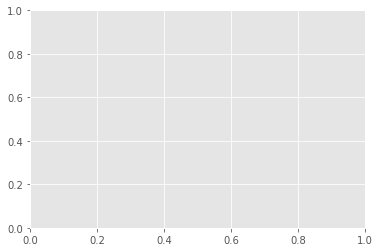

In [19]:
plotDecisionBoundary(knmodel, X_test, y_test)